# Machine learning to perform 7-day forecast on covid-19 in US
<p> Considering daily differencing, which will normalize the data as well, we can determine what magnitude of ranges in feature interactions will be at risk each day. Then, looking at that date's data, we can categorize states into "in risk" or "no risk"

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
np.set_printoptions(precision=4,suppress=True, threshold=4)

In [3]:
# append csv file names into an empty list to be iterated through afterwards
import os

csv_list = []

for files in sorted(os.listdir("csse_covid19_daily_us/.")):
    if files.endswith(".csv"):
        csv_list.append(files)
        
print(len(csv_list))
csv_list[:5]

100


['04-12-2020.csv',
 '04-13-2020.csv',
 '04-14-2020.csv',
 '04-15-2020.csv',
 '04-16-2020.csv']

In [4]:
# look over one dataframe
apr12 = pd.read_csv('csse_covid19_daily_us/'+csv_list[0])

print(apr12.info())
print("\nLooking over unfamiliar names:", apr12.Province_State.unique(), sep='\n\n')
print("\nColumns with NaNs: ", apr12.isnull().sum(), sep='\n\n')

apr12.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Province_State        59 non-null     object 
 1   Country_Region        59 non-null     object 
 2   Last_Update           56 non-null     object 
 3   Lat                   56 non-null     float64
 4   Long_                 56 non-null     float64
 5   Confirmed             59 non-null     int64  
 6   Deaths                59 non-null     int64  
 7   Recovered             29 non-null     float64
 8   Active                59 non-null     int64  
 9   FIPS                  57 non-null     float64
 10  Incident_Rate         56 non-null     float64
 11  People_Tested         56 non-null     float64
 12  People_Hospitalized   49 non-null     float64
 13  Mortality_Rate        57 non-null     float64
 14  UID                   59 non-null     int64  
 15  ISO3                  59 

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-12 23:18:15,32.3182,-86.9023,3563,93,NaN,3470,1.0,75.988020,21583.0,437.0,2.610160,84000001,USA,460.300152,12.264945
1,Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66.0,264,2.0,45.504049,8038.0,31.0,2.941176,84000002,USA,1344.711576,11.397059
2,Arizona,US,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,NaN,3427,4.0,48.662422,42109.0,NaN,3.246753,84000004,USA,578.522286,NaN
3,Arkansas,US,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367.0,1253,5.0,49.439423,19722.0,130.0,2.109375,84000005,USA,761.753354,10.156250
4,California,US,2020-04-12 23:18:15,36.1162,-119.6816,22795,640,NaN,22155,6.0,58.137726,190328.0,5234.0,2.812020,84000006,USA,485.423868,22.961176


(59, 10)
           Confirmed      Deaths     Recovered         Active  People_Tested  \
count      59.000000    59.00000     29.000000      59.000000      56.000000   
mean     9412.084746   373.20339   2315.137931    8479.762712   50105.214286   
std     25898.520388  1256.83882   7350.913086   25229.041344   71442.430285   
min         0.000000     0.00000      0.000000  -32988.000000       3.000000   
25%       728.500000    17.50000     83.000000     712.000000   10866.500000   
50%      1970.000000    70.00000    236.000000    1874.000000   26651.500000   
75%      7617.500000   268.00000    493.000000    7301.500000   56374.500000   
max    189033.000000  9385.00000  32988.000000  179648.000000  461601.000000   

       Testing_Rate  People_Hospitalized  Mortality_Rate  \
count     56.000000            49.000000       57.000000   
mean     939.956205          1882.673469        3.177029   
std      520.114034          6122.105749        2.417004   
min        5.391708           

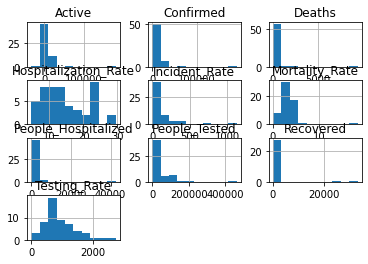

In [10]:
from pandas.plotting import scatter_matrix
from matplotlib import pyplot

# prep the April 12th dataset with columns of interest to summarize data
feature_cols = ['Confirmed', 'Deaths', 'Recovered', 'Active', 'People_Tested', 'Testing_Rate', 
                'People_Hospitalized', 'Mortality_Rate', 'Hospitalization_Rate', 'Incident_Rate']
apr12_ = apr12.loc[:, feature_cols]
# summarize the shape of the dataset
print(apr12_.shape)
# summarize each variable
print(apr12_.describe())
# histograms of the variables
apr12_.hist()
pyplot.show()

<p> Values vary in magnitude state by state, and it is difficult to gain much insight from unscaled data. Most of them, except for couple, are highly skewed. 
    
<p> Scaling will be necessary for our first part, which is to categorize data into "risk" or "no risk" based on feature interactions. This will be done per each date dataset, which then, will be fit into a model to train to perform as accurate prediction on which state is in category "risk" or "no risk". 
<hr>


# Transform data into daily difference

In [71]:
dropper_list = ['Diamond Princess', 'Grand Princess', 'Recovered']

feature_list = ['Province_State', 'Last_Update', 'Confirmed', 'Deaths', 
                'Recovered', 'Active', 'People_Tested', 'Testing_Rate', 
                'Mortality_Rate', 'Hospitalization_Rate', 'Incident_Rate']


def all_data_dict(filelist, state_filters, state_col):
    """Takes in a csv file string name,
    fills in missing date values with 'ffill' and 
    returns dataframes with column names lowercased 
    """ 
    daily_df = pd.concat({filelist[i][:-4]: 
                       pd.read_csv(''.join(['csse_covid19_daily_us/', filelist[i]]),
                      usecols=feature_list) for i in range(len(filelist))})

    daily_df.columns = daily_df.columns.str.lower()
    daily_df.rename(columns={state_col.lower(): 'state'}, inplace=True)
    daily_df.reset_index(level=[0,1], drop=True, inplace=True)
    

    return daily_df

allts = all_data_dict(csv_list, dropper_list, 'Province_State')
allts

,state,last_update,confirmed,deaths,recovered,active,incident_rate,people_tested,mortality_rate,testing_rate,hospitalization_rate
0,Alabama,2020-04-12 23:18:15,3563,93,NaN,3470.0,75.988020,21583.0,2.610160,460.300152,12.264945
1,Alaska,2020-04-12 23:18:15,272,8,66.0,264.0,45.504049,8038.0,2.941176,1344.711576,11.397059
2,Arizona,2020-04-12 23:18:15,3542,115,NaN,3427.0,48.662422,42109.0,3.246753,578.522286,NaN
3,Arkansas,2020-04-12 23:18:15,1280,27,367.0,1253.0,49.439423,19722.0,2.109375,761.753354,10.156250
4,California,2020-04-12 23:18:15,22795,640,NaN,22155.0,58.137726,190328.0,2.812020,485.423868,22.961176
...,...,...,...,...,...,...,...,...,...,...,...
5813,Virginia,2020-07-21 04:38:59,78375,2031,10107.0,66237.0,918.221845,920461.0,2.591388,10783.890236,14.373206
5814,Washington,2020-07-21 04:38:59,47743,1453,NaN,46290.0,626.968757,809339.0,3.043378,10628.369959,10.604696
5815,West Virginia,2020-07-21 04:38:59,5084,100,3466.0,1518.0,283.682086,234980.0,1.966955,13111.647649,NaN
5816,Wisconsin,2020-07-21 04:38:59,43018,846,33130.0,9042.0,738.831904,783866.0,1.966619,13462.857630,9.598308


In [356]:
# Create a new dictionary of each state's ts
dateidx = pd.DatetimeIndex(dates[:-4] for dates in csv_list)
dropper_list = ['Diamond Princess', 'Grand Princess', 'Recovered']

state_dict = {}
for name, statedf in allts.groupby('state'):
    if name not in dropper_list:
        statedf_ = statedf.copy()
        statedf_.fillna(0, axis=1, inplace=True)
        
        statedf_.drop(columns=['last_update'], axis=1, inplace=True)
        statedf_['date'] = dateidx
        statedf_.set_index(['date'], inplace=True)
        state_dict[name] = statedf_
        
fix_meancol = ['confirmed', 'active', 'mortality_rate']
statedf = pd.concat(state_dict)
statedf.reset_index(level=0,drop=True,inplace=True)
statedf.head()

,state,confirmed,deaths,recovered,active,incident_rate,people_tested,mortality_rate,testing_rate,hospitalization_rate
date,,,,,,,,,,
2020-04-12,Alabama,3563,93,0.0,3470.0,75.988020,21583.0,2.610160,460.300152,12.264945
2020-04-13,Alabama,3734,99,0.0,3635.0,79.634933,29182.0,2.651312,622.363852,12.238886
2020-04-14,Alabama,3953,114,0.0,3839.0,84.305541,33117.0,2.883886,706.285508,12.471541
2020-04-15,Alabama,4075,118,0.0,3957.0,86.907433,34077.0,2.895706,726.759406,12.883436
2020-04-16,Alabama,4345,133,0.0,4212.0,92.665716,36391.0,3.060990,776.110032,12.727273


<p> Before we move on to coverting data into differences, there are few issues with Florida for some reason. One of them, I overrided in the above loop by substituting the date column with csv file names (since Florida's April 13th's date was submitted as midnight next day). The other issue with Florida's 4/13 values will be substituted with April 12, 14, and 15th mean values. 

In [357]:
# fix Florida's April 13th data
fix_meancol = ['incident_rate', 'active']
fl = statedf[statedf.state == 'Florida']
fl13 = statedf.loc[(statedf.index == '2020-04-13') & (statedf['state'] == 'Florida')]
fl13_mort = fl13['deaths']/fl13['confirmed']*100
statedf.loc[(statedf.index == '2020-04-13') & (statedf['state'] == 'Florida'), 'mortality_rate'] = fl13_mort

for i in range(len(fix_meancol)):
    colname = fix_meancol[i]
    statedf.loc[(statedf.index == '2020-04-13') 
                & (statedf['state'] == 'Florida'), colname] = np.mean([fl.loc[fl.index=='2020-04-12', colname], 
                                                                       fl.loc[fl.index=='2020-04-14', colname],
                                                                       fl.loc[fl.index=='2020-04-15', colname]])

statedf.loc[(statedf.index == '2020-04-13') & (statedf['state'] == 'Florida')]


,state,confirmed,deaths,recovered,active,incident_rate,people_tested,mortality_rate,testing_rate,hospitalization_rate
date,,,,,,,,,,
2020-04-13,Florida,21019,499,0.0,20802.0,100.527776,196207.0,2.374043,924.083459,2.302896


# Scaling

#### Differencing

In [74]:
diff_dict = state_dict.copy()

for key, val in diff_dict.items():
    diff_dict[key] = val.iloc[:, 1:].diff()
    for col in diff_dict[key]:
        diff_dict[key][col].fillna(np.mean(diff_dict[key].iloc[:4][col]), inplace=True)
diff_dict

{'Alabama':               confirmed     deaths  recovered       active  incident_rate  \
 date                                                                        
 2020-04-12   170.666667   8.333333        0.0   162.333333       3.639804   
 2020-04-13   171.000000   6.000000        0.0   165.000000       3.646913   
 2020-04-14   219.000000  15.000000        0.0   204.000000       4.670608   
 2020-04-15   122.000000   4.000000        0.0   118.000000       2.601891   
 2020-04-16   270.000000  15.000000        0.0   255.000000       5.758284   
 ...                 ...        ...        ...          ...            ...   
 2020-07-16  2021.000000  19.000000        0.0  2002.000000      41.218106   
 2020-07-17  2003.000000  35.000000        0.0  1968.000000      40.850998   
 2020-07-18  2143.000000  21.000000        0.0  2122.000000      43.706285   
 2020-07-19  1777.000000   1.000000        0.0  1776.000000      36.241749   
 2020-07-20  1880.000000   4.000000        0.0  1876.

         confirmed      deaths   recovered       active  people_tested  \
count    56.000000   56.000000   56.000000    56.000000      56.000000   
mean    482.363095   37.535714   31.273810   444.827381    2600.375000   
std    1214.478358  106.769925   68.930417  1108.884568    3642.036292   
min       0.000000    0.000000   -2.666667     0.000000       0.000000   
25%      43.166667    1.583333    0.000000    41.416667     429.916667   
50%     118.500000    6.166667    0.000000   108.833333    1230.500000   
75%     399.666667   26.416667   41.166667   361.333333    3260.833333   
max    8473.666667  744.000000  378.666667  7729.666667   21470.333333   

       testing_rate  mortality_rate  hospitalization_rate  incident_rate  
count  5.600000e+01       56.000000             56.000000      56.000000  
mean   5.063254e+01        0.090927              0.237608       6.686550  
std    4.605657e+01        0.167649              1.309297       9.145828  
min   -7.257247e-11       -0.9324

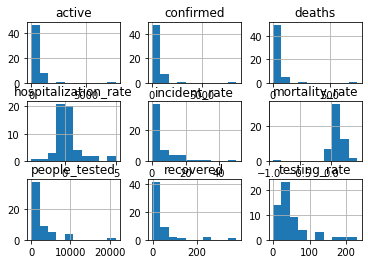

In [81]:
diffdf = pd.concat(diff_dict, names=['state', 'date']).reset_index(level=0)
feature_cols = [cols.lower() for cols in feature_list if cols not in ['Province_State', 'Last_Update']]

apr12dif = diffdf.loc[diffdf.index=='2020-04-12', feature_cols]
print(apr12dif.describe(), end='\n\n')
print(apr12dif.corr())
#[feature.lower() for feature in feature_list]
apr12dif.hist()
pyplot.show()

<p> Some features are still a bit skewed after daily differencing, but we're going to use median values later to mitigate that.

<AxesSubplot:>

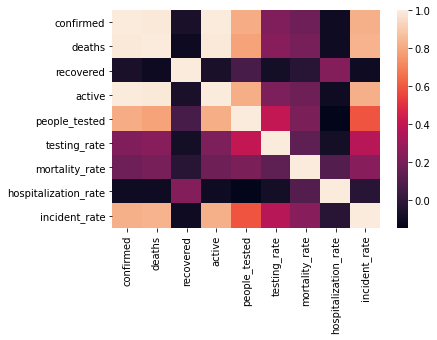

In [76]:
sns.heatmap(apr12dif.corr())

# Split training and test set (20% for each state's data)
- Perform time series train test split on each state's diff ts to get forecast for each state


In [359]:
train = {}
test = {}

for i in range(len(statedf.state.unique())):
    statename = statedf.state.unique()
    statedf_ = statedf[statedf.state == statename[i]]

    train[statename[i]] = statedf_.loc[:'2020-06-30']
    test[statename[i]] = statedf_.loc['2020-07-01':]


{'Alabama':               state  confirmed  deaths  recovered   active  incident_rate  \
 date                                                                        
 2020-04-12  Alabama       3563      93        0.0   3470.0      75.988020   
 2020-04-13  Alabama       3734      99        0.0   3635.0      79.634933   
 2020-04-14  Alabama       3953     114        0.0   3839.0      84.305541   
 2020-04-15  Alabama       4075     118        0.0   3957.0      86.907433   
 2020-04-16  Alabama       4345     133        0.0   4212.0      92.665716   
 ...             ...        ...     ...        ...      ...            ...   
 2020-06-26  Alabama      34183     907    18866.0  14410.0     697.159091   
 2020-06-27  Alabama      35083     919    18866.0  15298.0     715.514507   
 2020-06-28  Alabama      35441     919    18866.0  15656.0     722.815884   
 2020-06-29  Alabama      37175     929    18866.0  17380.0     758.180652   
 2020-06-30  Alabama      38045     950    18866.0  1

# Scaling
<p> We want to use daily data of all states. Based on the feature interaction of the day's aggregated differencing, we can figure out whether the state's for that day has combination of feature data belongs in "risk" or "no risk" group. </p>

1. get daily diff for each state, then group by date to aggregate median values. 
    - visualize each step
    
2. timetestsplit the aggregated time series to predict next day avg/median 

In [ ]:
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

# ADF test function [source: https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/]
def adf_test(ts):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfout = pd.Series(dftest[0:4], 
                      index=['Test Statistic','p-value',
                             '#Lags Used','Number of Observations Used'])
    for key, val in dftest[4].items():
        dfout['Critical Value (%s)'%key] = val
    print (dfout)



ORIGINAL DATA'S INCIDENT RATE: 
 date
2020-04-12     75.988020
2020-04-13     79.634933
2020-04-14     84.305541
2020-04-15     86.907433
2020-04-16     92.665716
2020-04-17     97.485613
2020-04-18    100.492717
2020-04-19    104.246265
2020-04-20    108.319718
2020-04-21    113.395538
Name: incident_rate, dtype: float64

DISTRIBUTION SUMMARY: 
 count     80.000000
mean     327.255442
std      196.053304
min       75.988020
25%      160.629461
50%      274.902946
75%      452.828111
max      775.924221
Name: incident_rate, dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                  5.908062
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64
STATIONARY TEST: 
 None



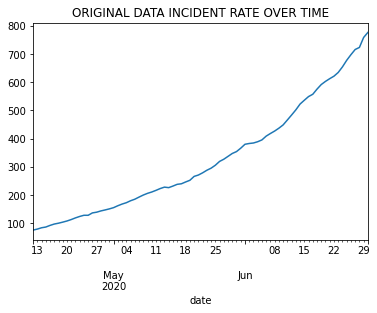

DAILY DIFFERENCES OF INCIDENT RATE:
 date
2020-04-12         NaN
2020-04-13    3.646913
2020-04-14    4.670608
2020-04-15    2.601891
2020-04-16    5.758284
2020-04-17    4.819897
2020-04-18    3.007104
2020-04-19    3.753548
2020-04-20    4.073453
2020-04-21    5.075821
Name: incident_rate, dtype: float64

DISTRIBUTION SUMMARY: 
 count    79.000000
mean      8.859952
std       6.123141
min      -1.794799
25%       4.795220
50%       6.931268
75%      11.829046
max      35.364768
Name: incident_rate, dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                  1.355239
p-value                         0.996901
#Lags Used                     12.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64
STATIONARY TEST: 
 None



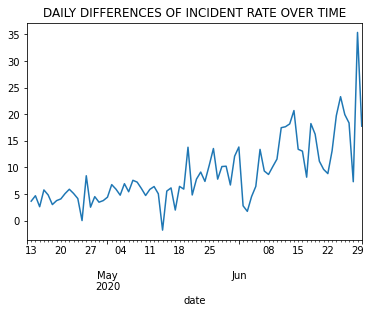

DAILY DIFFERENCES OF INCIDENT RATE:
 date
2020-04-12         NaN
2020-04-13         NaN
2020-04-14    1.023695
2020-04-15   -2.068717
2020-04-16    3.156393
2020-04-17   -0.938387
2020-04-18   -1.812793
2020-04-19    0.746444
2020-04-20    0.319905
2020-04-21    1.002368
Name: incident_rate, dtype: float64

DISTRIBUTION SUMMARY: 
 count    78.000000
mean      0.180726
std       5.509969
min     -17.621199
25%      -1.560210
50%       0.241066
75%       2.312863
max      28.063391
Name: incident_rate, dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                -5.729629e+00
p-value                        6.646518e-07
#Lags Used                     1.100000e+01
Number of Observations Used    6.800000e+01
Critical Value (1%)           -3.530399e+00
Critical Value (5%)           -2.905087e+00
Critical Value (10%)          -2.590001e+00
dtype: float64
STATIONARY TEST: 
 None



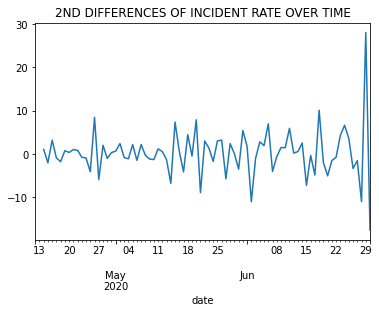

LOG + 1 CONVERSION OF INCIDENT RATE:
 date
2020-04-12    5.330576
2020-04-13    5.377453
2020-04-14    5.434448
2020-04-15    5.464844
2020-04-16    5.528999
2020-04-17    5.579705
2020-04-18    5.610085
2020-04-19    5.646756
2020-04-20    5.685087
2020-04-21    5.730882
Name: incident_rate, dtype: float64

DISTRIBUTION SUMMARY: 
 count    80.000000
mean      6.597507
std       0.648031
min       5.330576
25%       6.078932
50%       6.616318
75%       7.115375
max       7.654055
Name: incident_rate, dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                 -3.698811
p-value                         0.004130
#Lags Used                      0.000000
Number of Observations Used    79.000000
Critical Value (1%)            -3.515977
Critical Value (5%)            -2.898886
Critical Value (10%)           -2.586694
dtype: float64
STATIONARY TEST: 
 None



Text(0.5, 1.0, 'LOG + 1 CONVERSION OF INCIDENT RATE OVER TIME')

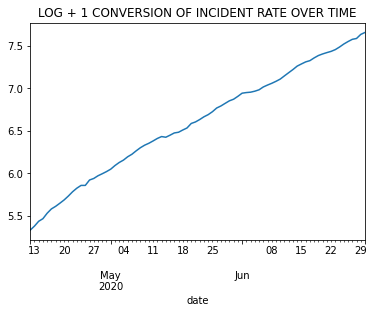

In [560]:
# concatenate every state's timeseries together 
traindf= pd.concat(train, names=['state', 'date'])

# take a look at one state data
state1 = traindf[traindf.state == 'Alabama'].reset_index(level='state', drop=True)

# visualize timeline of incident_rate
print("ORIGINAL DATA'S INCIDENT RATE: \n", state1.incident_rate[:10], end='\n\n')
print("DISTRIBUTION SUMMARY: \n", state1.incident_rate.describe(), end='\n\n')
print("STATIONARY TEST: \n", adf_test(state1.incident_rate), end='\n\n')
state1.incident_rate.plot()
plt.title("ORIGINAL DATA INCIDENT RATE OVER TIME")
plt.show()

state1_IRdif = state1.incident_rate.diff()
print("DAILY DIFFERENCES OF INCIDENT RATE:\n", state1_IRdif[:10], end='\n\n')
print("DISTRIBUTION SUMMARY: \n", state1_IRdif.describe(), end='\n\n')
print("STATIONARY TEST: \n", adf_test(state1_IRdif.fillna(method='bfill')), end='\n\n')
# plot differencing
state1_IRdif.plot()
plt.title("DAILY DIFFERENCES OF INCIDENT RATE OVER TIME")
plt.show()

state1_IRdif2 = state1_IRdif.diff()
print("DAILY DIFFERENCES OF INCIDENT RATE:\n", state1_IRdif2[:10], end='\n\n')
print("DISTRIBUTION SUMMARY: \n", state1_IRdif2.describe(), end='\n\n')
print("STATIONARY TEST: \n", adf_test(state1_IRdif2.fillna(method='bfill')), end='\n\n')
# plot differencing
state1_IRdif2.plot()
plt.title("2ND DIFFERENCES OF INCIDENT RATE OVER TIME")
plt.show()

# state's incident rate original values logged+1
state1_irLog1 = np.log(state1.incident_rate)+1
print("LOG + 1 CONVERSION OF INCIDENT RATE:\n", state1_irLog1[:10], end='\n\n')
print("DISTRIBUTION SUMMARY: \n", state1_irLog1.describe(), end='\n\n')
print("STATIONARY TEST: \n", adf_test(state1_irLog1), end='\n\n')
# plot log1 original
state1_irLog1.plot()
plt.title("LOG + 1 CONVERSION OF INCIDENT RATE OVER TIME")



<p> Differencing was not enough as a scale to transform the data into a stationary (looking just at incident_rate). <br><br>2nd differencing rid non-stationarity of incident rate for the state. <br><br>Log conversion, adding 1 to prevent dividing with 0 values, resulted in significant results to change the data into stationary.

         confirmed     deaths    recovered       active  incident_rate  \
count    80.000000  80.000000    80.000000    80.000000      80.000000   
mean      8.737500   0.187500     0.000000     8.550000       0.176208   
std     261.102276   9.796788  1494.807942  1529.586689       5.439850   
min    -864.000000 -22.000000 -7951.000000 -7810.000000     -17.621199   
25%     -75.500000  -7.000000     0.000000   -96.500000      -1.539815   
50%       6.000000   0.500000     0.000000   -15.500000       0.122369   
75%     103.500000   6.000000     0.000000    94.750000       2.206971   
max    1376.000000  23.000000  7951.000000  8020.000000      28.063391   

       people_tested  mortality_rate  testing_rate  hospitalization_rate  
count      80.000000       80.000000     80.000000             80.000000  
mean       72.000000       -0.000539      1.379898             -0.000324  
std      4604.502524        0.089968     97.034903              0.376599  
min    -16248.000000       -0.302

[]

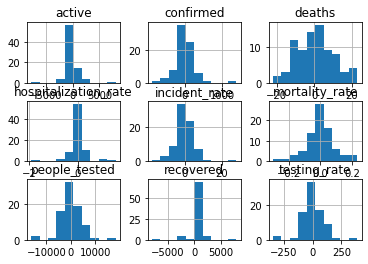

In [561]:
# transform entire data into 2nd diff
state1_ = state1.iloc[:, 1:]

state1diff2 = state1_.copy()
for cols in state1_:
    diff1 = state1_[cols].diff().fillna(method='bfill')
    state1diff2[cols] = diff1.diff().fillna(method='bfill')
    
print(state1diff2.describe())
[[print("\n{} Stationary Test:\n".format(cols).upper()), 
  adf_test(state1diff2[cols])] for cols in state1diff2]
state1diff2.hist()
pyplot.plot()


<p> 2nd Differencing adequately centers all features and transforms into a stationary dataset we can apply for timeseries forecasting.

In [568]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

# define the state's X, y (from training set)
X_vars = [
    'confirmed', 'deaths', 'recovered', 'mortality_rate', 
    'testing_rate', 'people_tested', 'hospitalization_rate'
]
state1diff2_X = state1diff2[X_vars]
state1diff2_y = state1diff2['incident_rate']

tss = TimeSeriesSplit(n_splits=5)

for train_idx, test_idx in tss.split(state1diff2_X):
    Xtrain_, Xtest_ = state1diff2_X.iloc[train_idx, :], state1diff2_X.iloc[test_idx,:]
    ytrain_, ytest_ = state1diff2_y.iloc[train_idx], state1diff2_y.iloc[test_idx]


In [570]:
decision_tree = DecisionTreeRegressor(max_depth=2)

#fit it using training data
decision_tree.fit(Xtrain_,ytrain_)

#evaluate the quality of the decision tree we created
print("Decision Tree RMSE:",np.sqrt(mean_squared_error(ytest_,decision_tree.predict(Xtest_))))

Decision Tree RMSE: 6.717344473122227


In [627]:
q1_, q3_ = np.percentile(state1diff2_y.values, [25, 75])
iqr_ = q3_ - q1_
low = q1_ - 1.5 * iqr_
hi = q3_ + 1.5 * iqr_

print("min ir: {}".format(state1diff2_y.min()))
print(iqr_)
print((low, hi))
print(".25: {}, .75: {}".format(q1_, q3_), end='\n\n')


state1diff2_y[state1diff2_y.values<-7.15999485]
low_outs = []
hi_outs = []
for x in list(range(101)):
    
    if np.percentile(state1diff2_y.values, x) < low:
        low_outs.append(x)
    elif np.percentile(state1diff2_y.values, x) > hi:
        hi_outs.append(x)
        
print(low_outs[-1])
print(hi_outs[0])

min ir: -17.62119928169136
3.7467862695920005
(-7.1599948508782525, 7.827150227489749)
.25: -1.5398154464902518, .75: 2.2069708231017486

5
97


# STOPPED HERE: 
START FROM CREATING NEW COLUMN OF CATEGORICAL/BIN VALUES FOR EACH ROW FOR THE STATE DIFF 2 DATA, THEN PERFORM POLY/RANDOM FOREST/CROSS VAL EVALUATION

In [ ]:
apr1.risk_mask = apr1.risk_mask.astype('int')
print(apr1.info())
apr1.sort_values(by='incident_rate')



apr1['risk_group'] = pd.qcut(apr1.incident_rate, q=[0.0, .87201, 1.], labels=['no risk', 'in risk'])
apr1

In [573]:
# Poly feature
from sklearn.preprocessing import PolynomialFeatures

polyfit_d2 = PolynomialFeatures(degree=2)
polyfitted_d2 = polyfit_d2.fit_transform(Xtrain_)

In [ ]:
from sklearn.model_selection import GridSearchCV

rf_grid = RandomForestClassifier(n_estimators=50,
                                 random_state=1,
                                 n_jobs=-1) #50 trees
max_depth_range = range(1, 11)
param_grid = dict(max_depth=max_depth_range)
print(param_grid)

grid = GridSearchCV(rf_grid,
                    param_grid,
                    cv=10,
                    scoring='accuracy')
grid.fit(X, y)

# examine the results of the grid search
grid.cv_results_